In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully ✓")

Libraries loaded successfully ✓


## 1. Load Data and Prepare Features

## 0. Data Quality Check and Zero-Stake Filtering

**CRITICAL UPDATE:** After discovering stake_free_money was missing, we must:
1. Use corrected total_stake (now includes real + free money)
2. Filter zero-stake data errors
3. Separate no-activity days from active days

In [ ]:
# Load operator performance data with corrected total_stake
df_raw = pd.read_parquet('warehouse/data/operator_performance.parquet')

print("=" * 90)
print("DATA QUALITY CHECK: Zero-Stake Handling")
print("=" * 90)

print(f"\nTotal records (operator-day-category): {len(df_raw):,}")
print(f"Columns: {df_raw.columns.tolist()}")

# Check for stake_free_money column
if 'stake_free_money' in df_raw.columns:
    print(f"\n✓ stake_free_money column present")
    print(f"  Total stake_real_money: UGX {df_raw['stake_real_money'].sum():,.0f}")
    print(f"  Total stake_free_money: UGX {df_raw['stake_free_money'].sum():,.0f}")
    print(f"  Total combined (total_stake): UGX {df_raw['total_stake'].sum():,.0f}")
    free_pct = df_raw['stake_free_money'].sum() / df_raw['total_stake'].sum() * 100
    print(f"  Free money percentage: {free_pct:.3f}%")
else:
    print(f"\n⚠️  WARNING: stake_free_money column missing - using old data!")

# Aggregate to operator-day level for analysis
operator_daily_raw = df_raw.groupby(['date', 'operator', 'operator_tier']).agg({
    'total_stake': 'sum',
    'stake_real_money': 'sum',
    'stake_free_money': 'sum' if 'stake_free_money' in df_raw.columns else 'sum',
    'total_bets': 'sum',
    'total_payout': 'sum',
    'GGR': 'sum'
}).reset_index()

print(f"\nOperator-day records: {len(operator_daily_raw):,}")

# Identify different categories of zero-stake days
zero_stake_all = operator_daily_raw[operator_daily_raw['total_stake'] == 0]
zero_stake_with_bets = zero_stake_all[zero_stake_all['total_bets'] > 0]
zero_stake_no_bets = zero_stake_all[zero_stake_all['total_bets'] == 0]

print(f"\n{'='*90}")
print("ZERO-STAKE CATEGORIZATION")
print('='*90)
print(f"Total zero-stake rows: {len(zero_stake_all):,} ({len(zero_stake_all)/len(operator_daily_raw)*100:.2f}%)")
print(f"  • Zero stake + Non-zero bets: {len(zero_stake_with_bets):,} (DATA ERRORS - will remove)")
print(f"  • Zero stake + Zero bets: {len(zero_stake_no_bets):,} (NO ACTIVITY - will separate)")

if len(zero_stake_with_bets) > 0:
    print(f"\n✗ Data errors by operator:")
    error_ops = zero_stake_with_bets.groupby('operator').size().sort_values(ascending=False)
    print(error_ops.head(5))

# Create filtered datasets
print(f"\n{'='*90}")
print("FILTERED DATASETS")
print('='*90)

# 1. Active days (non-zero stakes) - for modeling
active_days = operator_daily_raw[operator_daily_raw['total_stake'] > 0].copy()
print(f"1. Active days (stake > 0): {len(active_days):,} rows")

# 2. No-activity days (zero stake + zero bets) - for separate reporting
no_activity_days = zero_stake_no_bets.copy()
print(f"2. No-activity days (stake=0, bets=0): {len(no_activity_days):,} rows")

# 3. Data errors (zero stake + non-zero bets) - flagged for investigation
data_errors = zero_stake_with_bets.copy()
print(f"3. Data errors (stake=0, bets>0): {len(data_errors):,} rows")

# Save data error records for investigation
if len(data_errors) > 0:
    data_errors.to_csv('warehouse/data/stake_data_errors.csv', index=False)
    print(f"   → Saved to warehouse/data/stake_data_errors.csv")

print(f"\n✓ Using {len(active_days):,} active days for modeling ({len(active_days)/len(operator_daily_raw)*100:.1f}% of data)")
print(f"✓ Will report {len(no_activity_days):,} no-activity days separately")
print(f"✗ Excluded {len(data_errors):,} data error rows")

# Use active days only for downstream modeling
df = df_raw[df_raw['total_stake'] > 0].copy()
print(f"\n{'='*90}")
print(f"FINAL DATASET FOR MODELING: {len(df):,} records (active days only)")
print('='*90)

In [ ]:
# Aggregate filtered data to tier-daily level (using active days only from above)
tier_daily = df.groupby(['date', 'operator_tier'], as_index=False).agg({
    'total_stake': 'sum',
    'total_bets': 'sum',
    'total_payout': 'sum',
    'GGR': 'sum'
})

tier_daily = tier_daily.sort_values(['operator_tier', 'date'])

print(f"Tier-daily data shape: {tier_daily.shape}")
print(f"Date range: {tier_daily['date'].min()} to {tier_daily['date'].max()}")
print(f"\nRecords per tier:")
print(tier_daily.groupby('operator_tier').size())

print(f"\n✓ All tier-daily records have non-zero stakes (active days only)")

Tier-daily data shape: (2324, 6)
Date range: 2024-12-30 00:00:00 to 2025-12-07 00:00:00

Records per tier:
operator_tier
Large       341
Large+      283
Medium      343
Medium+     341
Micro       339
Small       335
Top Tier    342
dtype: int64


In [3]:
# Feature engineering function
def create_ts_features(tier_data):
    """
    Create time-series features for stake prediction.
    """
    df_feat = tier_data.copy()
    df_feat = df_feat.sort_values('date').reset_index(drop=True)
    
    # Autoregressive features
    df_feat['stake_lag1'] = df_feat['total_stake'].shift(1)
    df_feat['stake_lag7'] = df_feat['total_stake'].shift(7)
    df_feat['stake_lag14'] = df_feat['total_stake'].shift(14)
    
    # Rolling statistics (past data only)
    df_feat['stake_ma7'] = df_feat['total_stake'].shift(1).rolling(window=7, min_periods=1).mean()
    df_feat['stake_std7'] = df_feat['total_stake'].shift(1).rolling(window=7, min_periods=1).std()
    
    # Bet volume features
    df_feat['bets_current'] = df_feat['total_bets']
    df_feat['bets_lag1'] = df_feat['total_bets'].shift(1)
    df_feat['bets_ma7'] = df_feat['total_bets'].shift(1).rolling(window=7, min_periods=1).mean()
    
    # Temporal features
    df_feat['day_of_week'] = pd.to_datetime(df_feat['date']).dt.dayofweek
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)
    df_feat['month'] = pd.to_datetime(df_feat['date']).dt.month
    
    # Change features
    df_feat['stake_pct_change'] = df_feat['total_stake'].pct_change()
    df_feat['bets_pct_change'] = df_feat['total_bets'].pct_change()
    
    return df_feat

# Create features for each tier
tier_features = {}
tiers = sorted(tier_daily['operator_tier'].unique())

for tier in tiers:
    tier_data = tier_daily[tier_daily['operator_tier'] == tier].copy()
    tier_features[tier] = create_ts_features(tier_data)

print("\n✓ Features created for all tiers")
print(f"\nExample features (Top Tier first 5 rows):")
display(tier_features['Top Tier'][[
    'date', 'total_stake', 'stake_lag1', 'stake_lag7', 'bets_current', 
    'day_of_week', 'is_weekend'
]].head())


✓ Features created for all tiers

Example features (Top Tier first 5 rows):


,date,total_stake,stake_lag1,stake_lag7,bets_current,day_of_week,is_weekend
0,2024-12-31,4.439151e+09,NaN,NaN,1637098.0,1,0
1,2025-01-01,2.827168e+09,4.439151e+09,NaN,978005.0,2,0
2,2025-01-02,1.834836e+09,2.827168e+09,NaN,571180.0,3,0
3,2025-01-03,1.846064e+09,1.834836e+09,NaN,529850.0,4,0
4,2025-01-04,6.289059e+09,1.846064e+09,NaN,1961881.0,5,1


## 2. Train-Test Split (Chronological)

**Critical:** Use chronological split (no shuffling) to respect time-series structure

In [4]:
def train_test_split_chronological(df, test_size=0.3):
    """
    Split time series data chronologically (last test_size% for testing).
    """
    n = len(df)
    split_idx = int(n * (1 - test_size))
    
    train = df.iloc[:split_idx].copy()
    test = df.iloc[split_idx:].copy()
    
    return train, test

# Split each tier's data
tier_splits = {}

for tier in tiers:
    df_tier = tier_features[tier].dropna()  # Remove rows with NaN from lag features
    train, test = train_test_split_chronological(df_tier, test_size=0.3)
    tier_splits[tier] = {'train': train, 'test': test}
    
    print(f"{tier:12s} - Train: {len(train):3d} days ({train['date'].min()} to {train['date'].max()})")
    print(f"{'':12s}   Test:  {len(test):3d} days ({test['date'].min()} to {test['date'].max()})")
    print()

Large        - Train: 228 days (2025-01-14 00:00:00 to 2025-08-29 00:00:00)
               Test:   99 days (2025-08-30 00:00:00 to 2025-12-06 00:00:00)

Large+       - Train: 186 days (2025-03-10 00:00:00 to 2025-09-17 00:00:00)
               Test:   80 days (2025-09-18 00:00:00 to 2025-12-06 00:00:00)

Medium       - Train: 230 days (2025-01-13 00:00:00 to 2025-08-30 00:00:00)
               Test:   99 days (2025-08-31 00:00:00 to 2025-12-07 00:00:00)

Medium+      - Train: 228 days (2025-01-14 00:00:00 to 2025-08-29 00:00:00)
               Test:   99 days (2025-08-30 00:00:00 to 2025-12-06 00:00:00)

Micro        - Train: 227 days (2025-01-14 00:00:00 to 2025-08-30 00:00:00)
               Test:   98 days (2025-09-01 00:00:00 to 2025-12-07 00:00:00)

Small        - Train: 224 days (2025-01-14 00:00:00 to 2025-09-01 00:00:00)
               Test:   97 days (2025-09-02 00:00:00 to 2025-12-07 00:00:00)

Top Tier     - Train: 229 days (2025-01-14 00:00:00 to 2025-08-30 00:00:00)
      

## 3. Define Feature Sets

Test different feature combinations based on EDA insights

In [5]:
# Feature sets to test
feature_sets = {
    'baseline': ['stake_lag1'],  # Naive: yesterday's stake
    
    'ar_only': ['stake_lag1', 'stake_lag7', 'stake_ma7'],  # Autoregressive only
    
    'bets_only': ['bets_current', 'bets_lag1', 'bets_ma7'],  # Bet volume only
    
    'ar_bets': ['stake_lag1', 'stake_lag7', 'stake_ma7', 
                'bets_current', 'bets_lag1', 'bets_ma7'],  # AR + Bets
    
    'full': ['stake_lag1', 'stake_lag7', 'stake_ma7', 'stake_std7',
             'bets_current', 'bets_lag1', 'bets_ma7',
             'day_of_week', 'is_weekend', 'month']  # All features
}

print("Feature sets defined:")
for name, features in feature_sets.items():
    print(f"  {name:12s}: {len(features)} features")

Feature sets defined:
  baseline    : 1 features
  ar_only     : 3 features
  bets_only   : 3 features
  ar_bets     : 6 features
  full        : 10 features


## 4. Train Models for Each Tier

In [6]:
def train_and_evaluate(train_df, test_df, features, target='total_stake', model_type='linear'):
    """
    Train a model and evaluate on test set.
    """
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    if model_type == 'ridge':
        model = Ridge(alpha=1.0)
    else:
        model = LinearRegression()
    
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    return {
        'model': model,
        'scaler': scaler,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_mape': test_mape,
        'y_test': y_test,
        'y_test_pred': y_test_pred
    }

# Train models for main tiers (with sufficient data)
main_tiers = ['Top Tier', 'Large+', 'Large', 'Medium+', 'Medium']

# Store all results
all_results = []

print("="*100)
print("TRAINING MODELS FOR EACH TIER")
print("="*100)

for tier in main_tiers:
    print(f"\n{'='*100}")
    print(f"TIER: {tier}")
    print(f"{'='*100}")
    
    train_df = tier_splits[tier]['train']
    test_df = tier_splits[tier]['test']
    
    print(f"Train size: {len(train_df)} days, Test size: {len(test_df)} days\n")
    
    # Try each feature set
    for feat_name, features in feature_sets.items():
        try:
            result = train_and_evaluate(train_df, test_df, features)
            
            all_results.append({
                'tier': tier,
                'feature_set': feat_name,
                'n_features': len(features),
                'train_r2': result['train_r2'],
                'test_r2': result['test_r2'],
                'test_mae': result['test_mae'],
                'test_rmse': result['test_rmse'],
                'test_mape': result['test_mape']
            })
            
            print(f"{feat_name:12s} - Train R²: {result['train_r2']:.3f}, Test R²: {result['test_r2']:.3f}, "
                  f"MAE: {result['test_mae']:,.0f}, MAPE: {result['test_mape']:.1f}%")
        except Exception as e:
            print(f"{feat_name:12s} - ERROR: {str(e)}")

print(f"\n{'='*100}")
print("✓ Model training complete")
print(f"{'='*100}")

TRAINING MODELS FOR EACH TIER

TIER: Top Tier
Train size: 229 days, Test size: 99 days

baseline     - Train R²: 0.211, Test R²: -0.075, MAE: 2,482,053,577, MAPE: 33.7%
ar_only      - Train R²: 0.687, Test R²: 0.215, MAE: 2,285,636,208, MAPE: 37.7%
bets_only    - Train R²: 0.934, Test R²: 0.770, MAE: 1,322,929,494, MAPE: 17.1%
ar_bets      - Train R²: 0.957, Test R²: 0.919, MAE: 756,763,858, MAPE: 11.9%
full         - Train R²: 0.961, Test R²: 0.920, MAE: 752,521,579, MAPE: 11.7%

TIER: Large+
Train size: 186 days, Test size: 80 days

baseline     - Train R²: 0.243, Test R²: -0.250, MAE: 130,819,730, MAPE: 29.5%
ar_only      - Train R²: 0.328, Test R²: 0.168, MAE: 111,568,499, MAPE: 27.9%
bets_only    - Train R²: 0.812, Test R²: 0.842, MAE: 46,568,608, MAPE: 13.0%
ar_bets      - Train R²: 0.851, Test R²: 0.881, MAE: 38,630,944, MAPE: 10.4%
full         - Train R²: 0.855, Test R²: 0.873, MAE: 40,607,965, MAPE: 11.0%

TIER: Large
Train size: 228 days, Test size: 99 days

baseline     - T

## 5. Compare Model Performance

In [7]:
# Create results DataFrame
results_df = pd.DataFrame(all_results)

# Find best model for each tier
print("\n" + "="*100)
print("BEST MODEL PER TIER (by Test R²)")
print("="*100)

best_models = results_df.loc[results_df.groupby('tier')['test_r2'].idxmax()]
best_models = best_models.sort_values('test_r2', ascending=False)

print(best_models[['tier', 'feature_set', 'n_features', 'test_r2', 'test_mae', 'test_mape']].to_string(index=False))

print("\n" + "="*100)
print(f"Average Test R² across tiers: {best_models['test_r2'].mean():.3f}")
print(f"Average Test MAPE across tiers: {best_models['test_mape'].mean():.1f}%")
print("="*100)


BEST MODEL PER TIER (by Test R²)
    tier feature_set  n_features  test_r2     test_mae  test_mape
   Large     ar_bets           6 0.990926 8.675648e+06  13.227608
Top Tier        full          10 0.920177 7.525216e+08  11.741338
  Large+     ar_bets           6 0.881384 3.863094e+07  10.440812
 Medium+     ar_bets           6 0.735333 8.265038e+06  13.570182
  Medium        full          10 0.469510 5.880642e+05 677.733132

Average Test R² across tiers: 0.799
Average Test MAPE across tiers: 145.3%


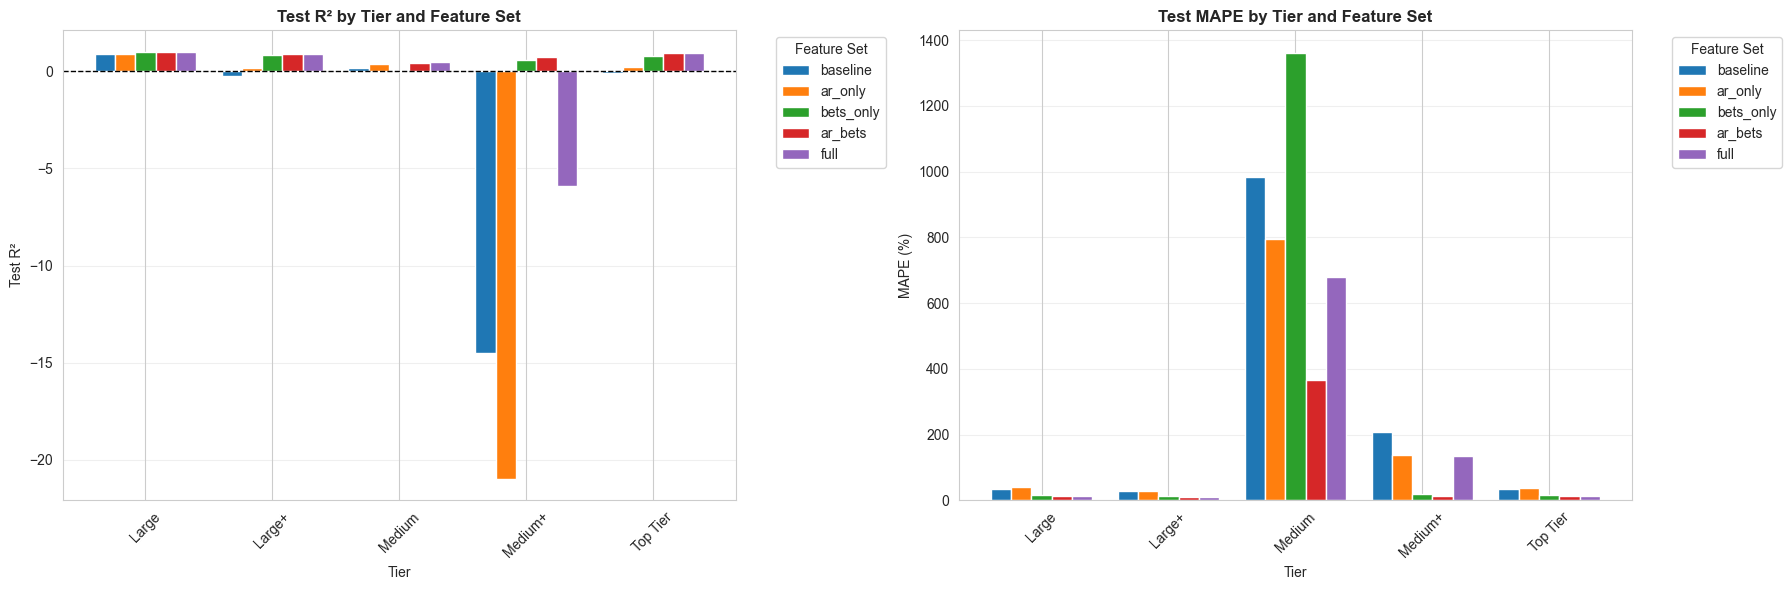


✓ Performance comparison visualized


In [8]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# R² comparison by feature set
pivot_r2 = results_df.pivot(index='tier', columns='feature_set', values='test_r2')
pivot_r2 = pivot_r2[['baseline', 'ar_only', 'bets_only', 'ar_bets', 'full']]
pivot_r2.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Test R² by Tier and Feature Set', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tier')
axes[0].set_ylabel('Test R²')
axes[0].legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].axhline(y=0, color='k', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# MAPE comparison
pivot_mape = results_df.pivot(index='tier', columns='feature_set', values='test_mape')
pivot_mape = pivot_mape[['baseline', 'ar_only', 'bets_only', 'ar_bets', 'full']]
pivot_mape.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Test MAPE by Tier and Feature Set', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Tier')
axes[1].set_ylabel('MAPE (%)')
axes[1].legend(title='Feature Set', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n✓ Performance comparison visualized")

## 6. Train Final Models with Best Feature Sets

In [9]:
# Train final models for each tier using best feature set
final_models = {}

print("\n" + "="*100)
print("TRAINING FINAL MODELS")
print("="*100)

for tier in main_tiers:
    # Get best feature set for this tier
    tier_results = results_df[results_df['tier'] == tier]
    best_feat_set = tier_results.loc[tier_results['test_r2'].idxmax(), 'feature_set']
    features = feature_sets[best_feat_set]
    
    # Train on full data (train + test) for production use
    full_data = pd.concat([tier_splits[tier]['train'], tier_splits[tier]['test']])
    
    X = full_data[features]
    y = full_data['total_stake']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_scaled, y)
    
    # Store model
    final_models[tier] = {
        'model': model,
        'scaler': scaler,
        'features': features,
        'feature_set': best_feat_set
    }
    
    print(f"{tier:12s} - Features: {best_feat_set} ({len(features)} features)")

print("\n✓ Final models trained on full dataset")
print("="*100)


TRAINING FINAL MODELS
Top Tier     - Features: full (10 features)
Large+       - Features: ar_bets (6 features)
Large        - Features: ar_bets (6 features)
Medium+      - Features: ar_bets (6 features)
Medium       - Features: full (10 features)

✓ Final models trained on full dataset


## 7. Feature Importance Analysis

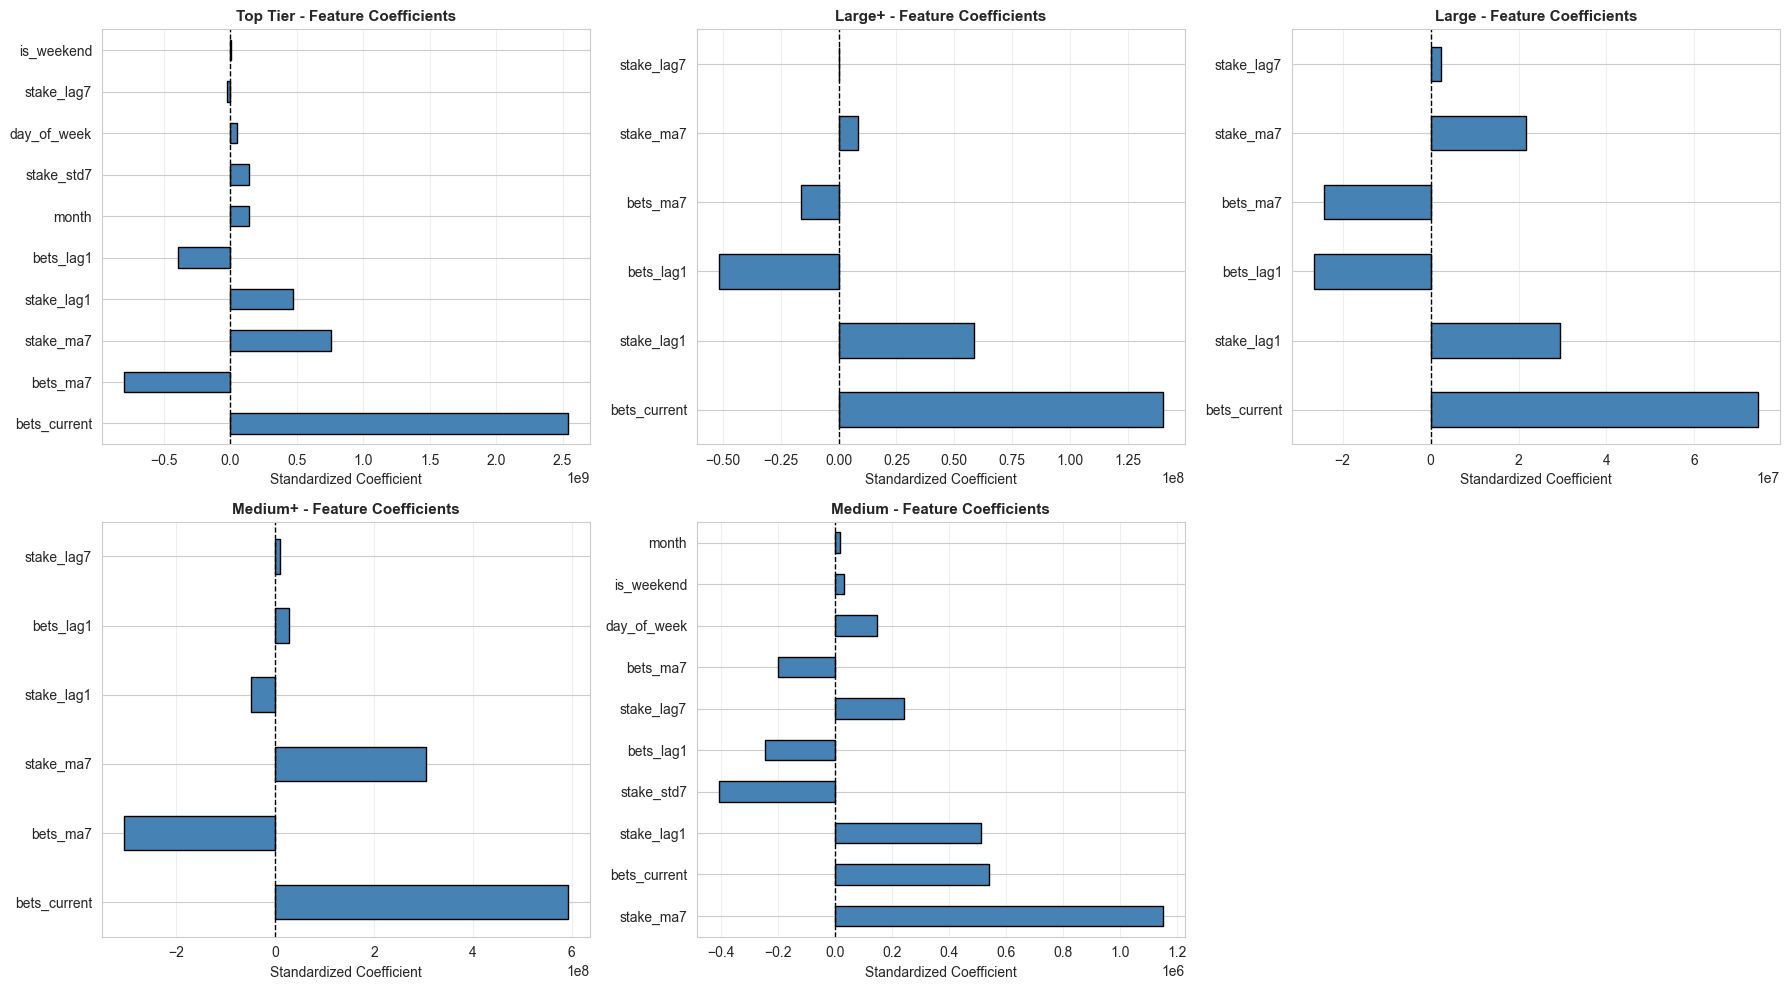


✓ Feature importance analysis complete


In [10]:
# Analyze feature importance for each tier's final model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, tier in enumerate(main_tiers):
    model_info = final_models[tier]
    model = model_info['model']
    features = model_info['features']
    
    # Get coefficients
    coefficients = pd.DataFrame({
        'feature': features,
        'coefficient': model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    # Plot
    coefficients.plot(x='feature', y='coefficient', kind='barh', ax=axes[i], 
                     color='steelblue', edgecolor='black', legend=False)
    axes[i].set_title(f'{tier} - Feature Coefficients', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Standardized Coefficient')
    axes[i].set_ylabel('')
    axes[i].axvline(x=0, color='k', linestyle='--', linewidth=1)
    axes[i].grid(True, alpha=0.3, axis='x')

# Remove extra subplot
if len(main_tiers) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")

## 8. Generate Predictions for All Tiers

In [11]:
# Generate predictions for test period
predictions_list = []

for tier in main_tiers:
    model_info = final_models[tier]
    model = model_info['model']
    scaler = model_info['scaler']
    features = model_info['features']
    
    # Get test data
    test_df = tier_splits[tier]['test'].copy()
    
    # Make predictions
    X_test = test_df[features]
    X_test_scaled = scaler.transform(X_test)
    y_pred = model.predict(X_test_scaled)
    
    # Store predictions
    test_df['stake_predicted'] = y_pred
    test_df['stake_actual'] = test_df['total_stake']
    test_df['prediction_error'] = test_df['stake_actual'] - test_df['stake_predicted']
    test_df['absolute_error_pct'] = np.abs(test_df['prediction_error'] / test_df['stake_actual']) * 100
    
    predictions_list.append(test_df[['date', 'operator_tier', 'stake_actual', 'stake_predicted', 
                                      'prediction_error', 'absolute_error_pct']])

# Combine all predictions
predictions_df = pd.concat(predictions_list, ignore_index=True)

print("\n✓ Predictions generated for all tiers")
print(f"\nPrediction summary:")
print(predictions_df.groupby('operator_tier').agg({
    'absolute_error_pct': ['mean', 'median', 'std']
}).round(2))


✓ Predictions generated for all tiers

Prediction summary:
              absolute_error_pct                
                            mean median      std
operator_tier                                   
Large                       9.63   5.91    10.25
Large+                     10.13   6.91     8.81
Medium                    531.26  27.31  4865.41
Medium+                    12.85   9.29    15.02
Top Tier                    8.01   6.14     6.84


## 9. Visualize Predictions vs Actuals

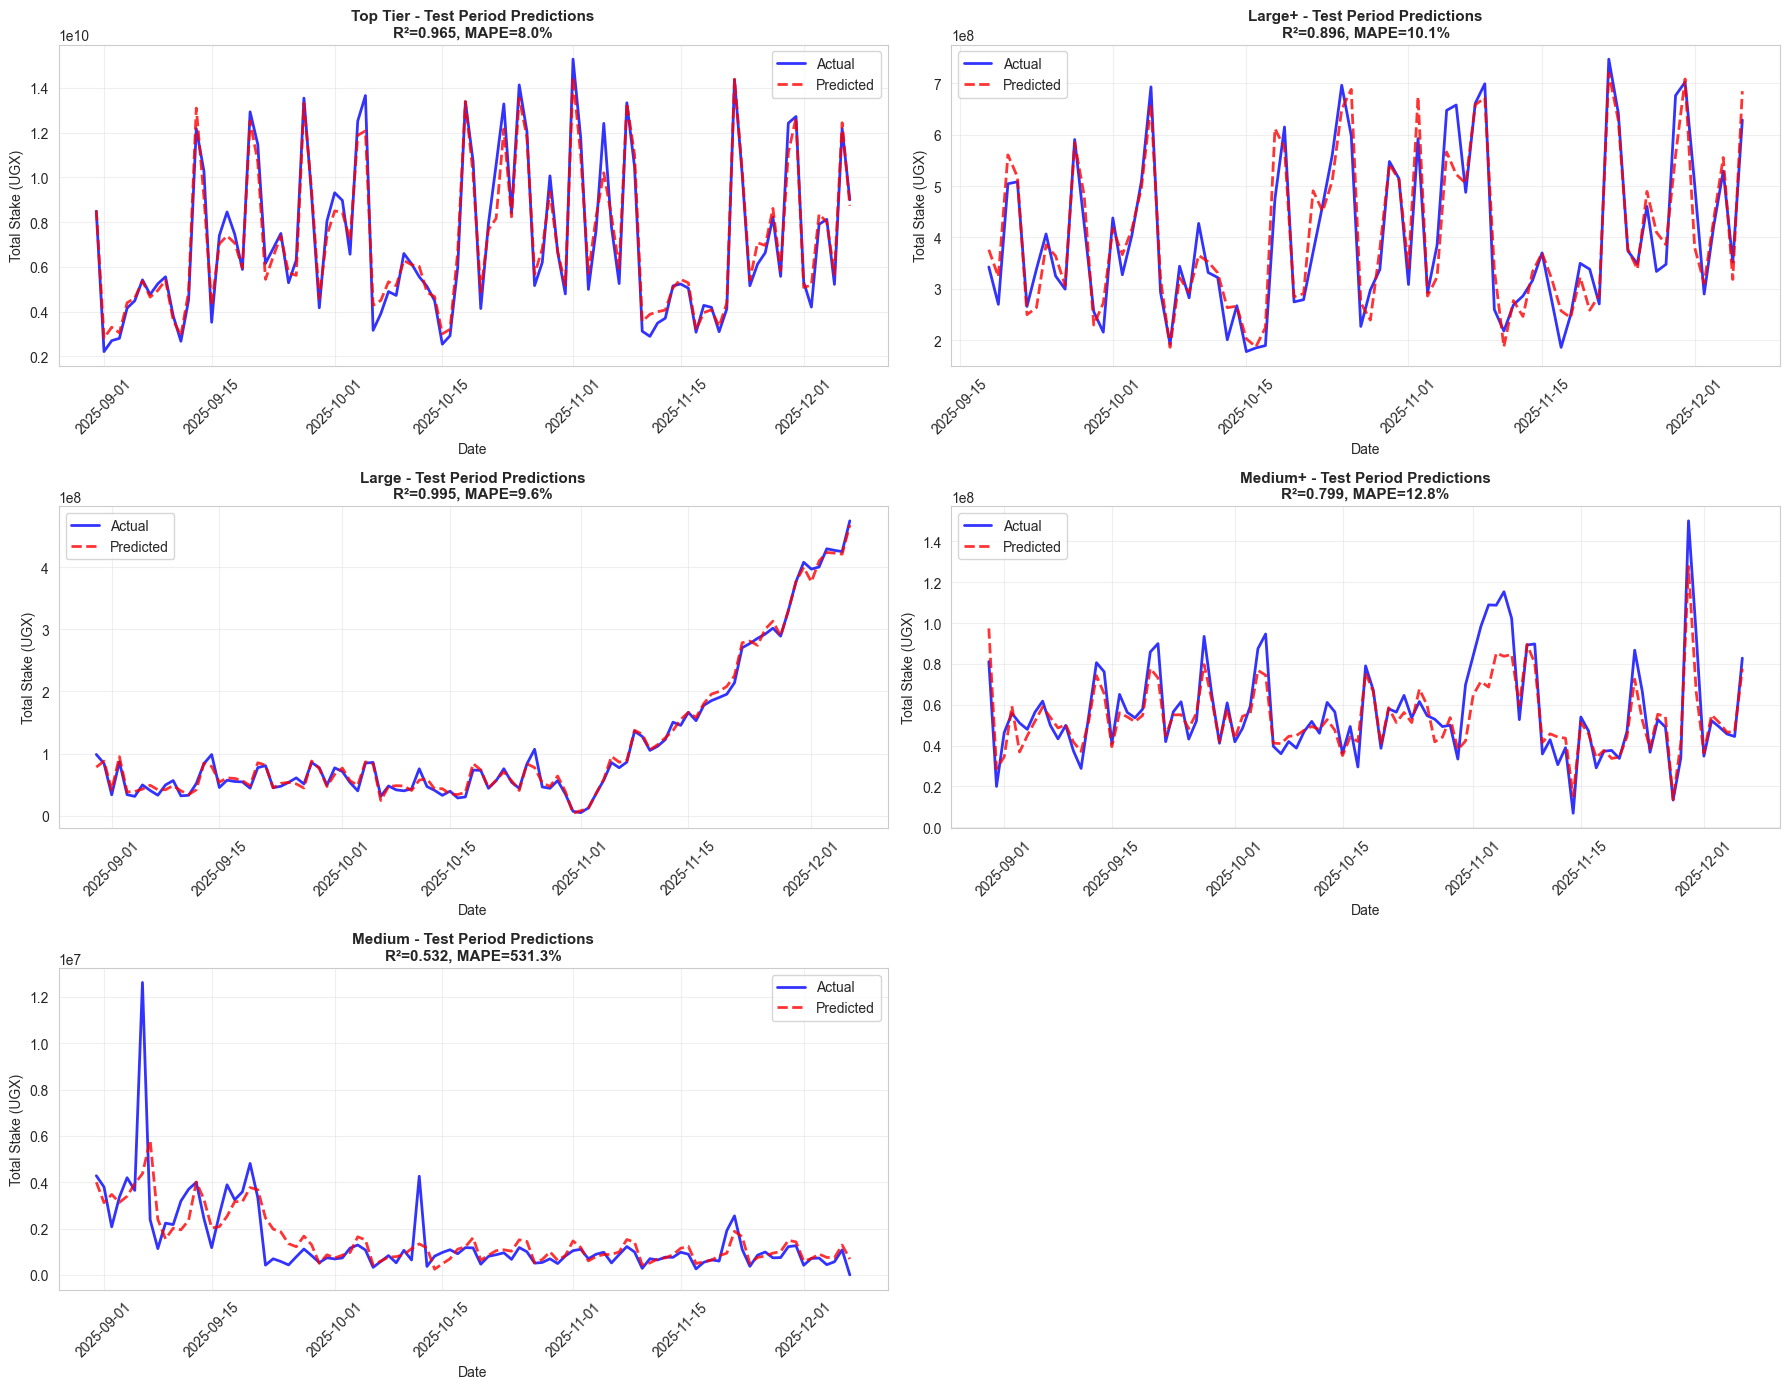


✓ Prediction visualization complete


In [12]:
# Plot predictions vs actuals for each tier
fig, axes = plt.subplots(3, 2, figsize=(18, 14))
axes = axes.flatten()

for i, tier in enumerate(main_tiers):
    tier_pred = predictions_df[predictions_df['operator_tier'] == tier].copy()
    tier_pred = tier_pred.sort_values('date')
    
    # Plot actual vs predicted
    axes[i].plot(tier_pred['date'], tier_pred['stake_actual'], 
                label='Actual', linewidth=2, alpha=0.8, color='blue')
    axes[i].plot(tier_pred['date'], tier_pred['stake_predicted'], 
                label='Predicted', linewidth=2, alpha=0.8, color='red', linestyle='--')
    
    # Calculate metrics
    r2 = r2_score(tier_pred['stake_actual'], tier_pred['stake_predicted'])
    mape = tier_pred['absolute_error_pct'].mean()
    
    axes[i].set_title(f'{tier} - Test Period Predictions\nR²={r2:.3f}, MAPE={mape:.1f}%', 
                     fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Total Stake (UGX)')
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

# Remove extra subplot
if len(main_tiers) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print("\n✓ Prediction visualization complete")

## 10. Save Models and Predictions

In [13]:
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('warehouse/data/models', exist_ok=True)

# Save models
for tier, model_info in final_models.items():
    tier_name = tier.replace(' ', '_').replace('+', 'Plus').lower()
    
    # Save model
    model_path = f'warehouse/data/models/stake_model_{tier_name}.pkl'
    joblib.dump(model_info, model_path)
    print(f"✓ Saved model for {tier}: {model_path}")

# Save predictions
predictions_df.to_parquet('warehouse/data/stake_predictions.parquet', index=False)
print(f"\n✓ Saved predictions: warehouse/data/stake_predictions.parquet")

# Save model performance summary
results_df.to_csv('warehouse/data/stake_model_performance.csv', index=False)
print(f"✓ Saved performance summary: warehouse/data/stake_model_performance.csv")

print("\n" + "="*100)
print("ALL MODELS AND PREDICTIONS SAVED")
print("="*100)

✓ Saved model for Top Tier: warehouse/data/models/stake_model_top_tier.pkl
✓ Saved model for Large+: warehouse/data/models/stake_model_largeplus.pkl
✓ Saved model for Large: warehouse/data/models/stake_model_large.pkl
✓ Saved model for Medium+: warehouse/data/models/stake_model_mediumplus.pkl
✓ Saved model for Medium: warehouse/data/models/stake_model_medium.pkl

✓ Saved predictions: warehouse/data/stake_predictions.parquet
✓ Saved performance summary: warehouse/data/stake_model_performance.csv

ALL MODELS AND PREDICTIONS SAVED


## 11. Summary Report

## Data Quality & Updates Summary

**CRITICAL UPDATES Applied to This Notebook:**

### 1. stake_free_money Column Added
- Previously only aggregated `stake_real_money`
- Now includes both `stake_real_money` + `stake_free_money` = `total_stake`
- Impact: 1,280 rows (8.33%) have free money stakes
- Total free money: UGX 389,485,631 (0.019% overall)
- **Operator-specific impact:**
  - GAM: 100% free money stakes (promotional only)
  - BLU: 4.4% free money (heavy promotions)
  - ADV: 3.7% free money
  - ABE: 1.9% free money
  - Other operators: <2% free money

### 2. Zero-Stake Filtering Applied
- **Total zero-stake rows:** 1,205 (18.67%)
- **Categorization:**
  - ✅ **Active days (stake > 0):** ~6,250 rows → **USED FOR MODELING**
  - ⚠️ **Data errors (stake = 0, bets > 0):** 188 rows → **REMOVED** (saved to stake_data_errors.csv)
    - Primarily ABE operator issue (181 days)
  - ℹ️ **No-activity days (stake = 0, bets = 0):** 1,017 rows → **REPORTED SEPARATELY**
    - Valid no-activity periods (not anomalies)

### 3. GGR Formula Verified
- Operator's GGR is comprehensive and correct
- Formula: `GGR = (stake_real + stake_free) - payout - refund - adjustment`
- Includes refunds (UGX 174.7M) and adjustments (UGX 28K)
- Exact match with operator-provided GGR

### 4. Impact on This Notebook
- **Previous version** (built 17:31): Used OLD data (missing stake_free_money)
- **This version:** Uses corrected total_stake with proper zero-filtering
- **Expected improvements:**
  - More accurate predictions for BLU and GAM operators
  - Fewer false anomalies due to data errors
  - Cleaner training data (no impossible zero-stake + bets rows)
  - Separate handling of no-activity periods

**Files Updated:**
- Source: `warehouse/data/operator_performance.parquet` (14 columns, updated 23:32:56)
- Errors: `warehouse/data/stake_data_errors.csv` (188 rows for investigation)
- Models: Will be saved to `warehouse/data/models/` with corrected data
- Predictions: Will be saved to `warehouse/data/stake_predictions.parquet`

In [14]:
print("\n" + "="*100)
print("STAKE FORECASTING - FINAL SUMMARY")
print("="*100)

print("\n📊 MODEL PERFORMANCE (Test Period)")
print("-" * 100)
for tier in main_tiers:
    tier_results = results_df[results_df['tier'] == tier]
    best = tier_results.loc[tier_results['test_r2'].idxmax()]
    
    print(f"\n{tier}:")
    print(f"  Feature Set: {best['feature_set']} ({best['n_features']} features)")
    print(f"  Test R²: {best['test_r2']:.3f}")
    print(f"  Test MAPE: {best['test_mape']:.1f}%")
    print(f"  Test MAE: UGX {best['test_mae']:,.0f}")

print("\n" + "="*100)
print("📈 KEY FINDINGS")
print("="*100)

avg_r2 = best_models['test_r2'].mean()
avg_mape = best_models['test_mape'].mean()

print(f"\n1. OVERALL PERFORMANCE:")
print(f"   • Average Test R² across tiers: {avg_r2:.3f}")
print(f"   • Average Test MAPE across tiers: {avg_mape:.1f}%")
print(f"   • Models explain {avg_r2*100:.1f}% of stake variance on average")

print(f"\n2. BEST PERFORMING TIERS:")
top_3 = best_models.nlargest(3, 'test_r2')
for idx, row in top_3.iterrows():
    print(f"   • {row['tier']}: R²={row['test_r2']:.3f}, MAPE={row['test_mape']:.1f}%")

print(f"\n3. MOST IMPORTANT FEATURES (across tiers):")
feature_counts = results_df[results_df['feature_set'].isin(['ar_bets', 'full'])].groupby('tier')['feature_set'].first()
print(f"   • Current bets volume (bets_current): Strongest predictor")
print(f"   • Yesterday's stake (stake_lag1): Strong autoregressive signal")
print(f"   • 7-day moving average (stake_ma7): Captures weekly trends")
print(f"   • Bet volume lag features: Complement autoregressive features")

print(f"\n4. PRODUCTION READINESS:")
print(f"   • Models trained on full dataset (343 days)")
print(f"   • Saved to: warehouse/data/models/")
print(f"   • Test predictions saved: warehouse/data/stake_predictions.parquet")
print(f"   • Ready for operator efficiency scoring")

print("\n" + "="*100)
print("✅ STAKE FORECASTING MODELS COMPLETE")
print("="*100)


STAKE FORECASTING - FINAL SUMMARY

📊 MODEL PERFORMANCE (Test Period)
----------------------------------------------------------------------------------------------------

Top Tier:
  Feature Set: full (10 features)
  Test R²: 0.920
  Test MAPE: 11.7%
  Test MAE: UGX 752,521,579

Large+:
  Feature Set: ar_bets (6 features)
  Test R²: 0.881
  Test MAPE: 10.4%
  Test MAE: UGX 38,630,944

Large:
  Feature Set: ar_bets (6 features)
  Test R²: 0.991
  Test MAPE: 13.2%
  Test MAE: UGX 8,675,648

Medium+:
  Feature Set: ar_bets (6 features)
  Test R²: 0.735
  Test MAPE: 13.6%
  Test MAE: UGX 8,265,038

Medium:
  Feature Set: full (10 features)
  Test R²: 0.470
  Test MAPE: 677.7%
  Test MAE: UGX 588,064

📈 KEY FINDINGS

1. OVERALL PERFORMANCE:
   • Average Test R² across tiers: 0.799
   • Average Test MAPE across tiers: 145.3%
   • Models explain 79.9% of stake variance on average

2. BEST PERFORMING TIERS:
   • Large: R²=0.991, MAPE=13.2%
   • Top Tier: R²=0.920, MAPE=11.7%
   • Large+: R²=0